In [ ]:
pip install yfinance

In [ ]:
pip install yahoo-finance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.2 MB/s eta 0:00:00
  Created wheel for yahoo-finance: filename=yahoo_finance-1.4.0-py3-none-any.whl size=7216 sha256=477428a7a41c2775af5894602937cb6beb96f9aed10e7dba736d20b6c589958c
  Stored in directory: /root/.cache/pip/wheels/f6/a9/34/f1aaa343d0861148f79a9df08f380e4dbbdbe27b7ba1e0e84c
Successfully built yahoo-finance


In [ ]:
pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.15-py3-none-any.whl size=28713 sha256=21e5340af934d1a88b3e18d03f85231d6d755b11e3e150ecaac41c4b2154c5dd
  Stored in directory: /root/.cache/pip/wheels/06/9c/4b/0566bbb720cdf54370f921f20d259a26392099760a37827811
Successfully built yahoofinancials


In [ ]:
# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Descargar datos de yahoo
import yfinance as yf
from yahoofinancials import YahooFinancials

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from datetime import datetime, timedelta
from timeit import default_timer as timer

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")

## Extracción del Precio del Mercado Seleccionado

In [ ]:
df = yf.download("GC=F",
                      #start='1992-01-02',
                      start='2022-01-02',
                      end=datetime.now(),
                      progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1830.099976,1830.099976,1798.800049,1799.400024,1799.400024,116
2022-01-04,1800.500000,1815.300049,1800.000000,1814.000000,1814.000000,38
2022-01-05,1813.099976,1824.599976,1813.099976,1824.599976,1824.599976,8
2022-01-06,1787.099976,1791.300049,1787.099976,1788.699951,1788.699951,30
2022-01-07,1791.800049,1797.000000,1784.400024,1797.000000,1797.000000,17
...,...,...,...,...,...,...
2023-06-26,1922.900024,1928.500000,1922.500000,1923.699951,1923.699951,71
2023-06-27,1927.000000,1929.400024,1914.000000,1914.000000,1914.000000,49
2023-06-28,1912.300049,1912.300049,1912.300049,1912.300049,1912.300049,628


In [ ]:
df = df.drop(["Open"],axis=1)
df = df.drop(["High"],axis=1)
df = df.drop(["Low"],axis=1)
df = df.drop(["Adj Close"],axis=1)
df = df.drop(["Volume"],axis=1)
df

,Close
Date,
2022-01-03,1799.400024
2022-01-04,1814.000000
2022-01-05,1824.599976
2022-01-06,1788.699951
2022-01-07,1797.000000
...,...
2023-06-26,1923.699951
2023-06-27,1914.000000
2023-06-28,1912.300049


In [ ]:
df = df.asfreq(freq = 'D', method = 'ffill')
df

,Close
Date,
2022-01-03,1799.400024
2022-01-04,1814.000000
2022-01-05,1824.599976
2022-01-06,1788.699951
2022-01-07,1797.000000
...,...
2023-06-26,1923.699951
2023-06-27,1914.000000
2023-06-28,1912.300049


In [ ]:
fig = px.line(df, x = df.index, y = df['Close'],template = "plotly_dark", title = "Gráfico de índice seleccionado")
fig.show()

## División de Datos para Entenamiento y Prueba

In [ ]:
train_data = df[:round(len(df) * 0.8)]
test_data = df[round(len(df) * 0.8):]
test = test_data.copy()
train_data.shape, test_data.shape, df.shape

((435, 1), (109, 1), (544, 1))

## Estandarización de los Datos con la Prueba de Dickey-Fuller Aumentada

In [ ]:
def Prueba_Dickey_Fuller(precio , nombre_columna):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {nombre_columna}')
    dftest = adfuller(precio, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion: ====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion: ====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [ ]:
Prueba_Dickey_Fuller(df["Close"],"Close")

Resultados de la prueba de Dickey-Fuller para columna: Close
Test Statistic                         -1.426103
p-value                                 0.569700
No Lags Used                            1.000000
Número de observaciones utilizadas    542.000000
Critical Value (1%)                    -3.442473
Critical Value (5%)                    -2.866887
Critical Value (10%)                   -2.569618
dtype: float64
Conclusion: ====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
train_data_escalado = scaler.transform(train_data)
test_data_escalado = scaler.transform(test_data)
test_data_escalado

array([[0.67874269],
       [0.72768709],
       [0.70945298],
       [0.83133412],
       [0.83133412],
       [0.83133412],
       [0.85388667],
       [0.7550384 ],
       [0.77615177],
       [0.8889157 ],
       [0.86084451],
       [0.86084451],
       [0.86084451],
       [0.78958741],
       [0.83757207],
       [0.82245678],
       [0.85652606],
       [0.82941462],
       [0.82941462],
       [0.82941462],
       [0.86516324],
       [0.95705368],
       [0.95393485],
       [0.93234176],
       [0.93234176],
       [0.93234176],
       [0.93234176],
       [0.87763913],
       [0.91530726],
       [0.92994252],
       [1.00287925],
       [0.90906902],
       [0.90906902],
       [0.90906902],
       [0.88987516],
       [0.92154521],
       [0.89227439],
       [0.92202494],
       [0.85460656],
       [0.85460656],
       [0.85460656],
       [0.87763913],
       [0.88939543],
       [0.86948168],
       [0.87955864],
       [0.88003837],
       [0.88003837],
       [0.880

--------------------------PRIMERA FORMA--------------------------

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 1
n_features= 1
generator = TimeseriesGenerator(train_data_escalado, train_data_escalado, length = n_input, batch_size = 1)
generator[1]

(array([[[0.45753355]]]), array([[0.48296536]]))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

modelo_LSTM = Sequential()
modelo_LSTM.add(LSTM(units = 365, activation = 'relu', input_shape = (n_input, n_features)))
modelo_LSTM.add(Dense(1))
modelo_LSTM.compile(optimizer = 'adam', loss = 'mse')

modelo_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365)               535820    
                                                                 
 dense (Dense)               (None, 1)                 366       
                                                                 
Total params: 536,186
Trainable params: 536,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo_LSTM.fit_generator(generator, epochs = 20)

Epoch 1/20
434/434 [==============================] - 14s 13ms/step - loss: 0.0254
Epoch 2/20
434/434 [==============================] - 4s 8ms/step - loss: 0.0018
Epoch 3/20
434/434 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 4/20
434/434 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 5/20
434/434 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 6/20
434/434 [==============================] - 3s 6ms/step - loss: 0.0015
Epoch 7/20
434/434 [==============================] - 3s 8ms/step - loss: 0.0015
Epoch 8/20
434/434 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 9/20
434/434 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 10/20
434/434 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 11/20
434/434 [==============================] - 3s 7ms/step - loss: 0.0014
Epoch 12/20
434/434 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 13/20
434/434 [==

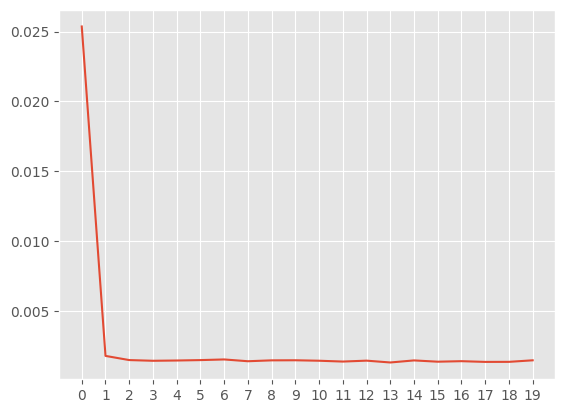

In [ ]:
perdida_LSTM = modelo_LSTM.history.history['loss']
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(perdida_LSTM)),perdida_LSTM);

In [ ]:
predicciones_escaladas_LSTM = list()

batch = train_data_escalado[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data + 1)):
    prediccion_LSTM = modelo_LSTM.predict(current_batch)[0]
    predicciones_escaladas_LSTM.append(prediccion_LSTM)
    current_batch = np.append(current_batch[:,1:,:],[[prediccion_LSTM]],axis=1)

1/1 [==============================] - 0s 30ms/step


In [ ]:
predicciones_LSTM = scaler.inverse_transform(predicciones_escaladas_LSTM)
predicciones_LSTM

array([[1911.88237193],
       [1912.06382674],
       [1912.24433752],
       [1912.42387941],
       [1912.60245241],
       [1912.78008138],
       [1912.9567663 ],
       [1913.13255686],
       [1913.30742823],
       [1913.4813804 ],
       [1913.65443821],
       [1913.82662651],
       [1913.9979453 ],
       [1914.16839457],
       [1914.33797433],
       [1914.50670942],
       [1914.67459985],
       [1914.84167045],
       [1915.00789638],
       [1915.17332732],
       [1915.33796328],
       [1915.50177942],
       [1915.66480058],
       [1915.82702675],
       [1915.98850762],
       [1916.14919352],
       [1916.30913411],
       [1916.46832941],
       [1916.62675457],
       [1916.78443444],
       [1916.94139385],
       [1917.0976328 ],
       [1917.25312646],
       [1917.40792452],
       [1917.56202696],
       [1917.71543379],
       [1917.86814501],
       [1918.02016062],
       [1918.17148062],
       [1918.3221547 ],
       [1918.47215801],
       [1918.621

In [ ]:
test_data['Predicciones_LSTM'] = predicciones_LSTM
test_data

,Close,Predicciones_LSTM
Date,,
2023-03-14,1906.199951,1911.882372
2023-03-15,1926.599976,1912.063827
2023-03-16,1919.000000,1912.244338
2023-03-17,1969.800049,1912.423879
2023-03-18,1969.800049,1912.602452
...,...,...
2023-06-26,1923.699951,1926.930800
2023-06-27,1914.000000,1927.048308
2023-06-28,1912.300049,1927.165469


In [ ]:
ai=test_data[["Close","Predicciones_LSTM"]]
fig = px.line(ai, x = test_data.index, y = ai.columns, title = "Predicción con Modelo LSTM", template = "plotly_dark")
fig.show()